In [40]:
import quandl
import pandas as pd
import numpy as np
import sys
from math import sqrt
from bokeh.plotting import figure, show
from bokeh.models import Range1d
from bokeh.io import output_notebook
output_notebook()
from scipy.interpolate import interp1d
from bokeh.models import HoverTool

Loading BokehJS ...

In [58]:
# The stock list that quandl will gather historical closing price information
#
stock_list = ['AAPL', 'MCD', 'BK','STZ','JNJ','DIS','MSFT','FB','KO','UNP','NFLX','GS','AMZN','BRK.B','CWT']

In [59]:
# The quandl api call that returns the historical pricing information and stores the data in a table
# The columns I've requested are the ticker, the closing price and the associated date
#
quandl.ApiConfig.api_key = 'XJHgYSZCnRCrRojEbr9y'
raw_data=quandl.get_table("SHARADAR/SEP", qopts={"columns":['ticker','date','close']},ticker=stock_list, paginate=True)

# The data is pivoted so that the column headings are the ticker symbols and the date is the index
#
quandl_data = raw_data.pivot(index='date',columns='ticker', values='close')

In [60]:
# Some quotes are not found in quandl. I needed to download pricing data from yahoo and upload as a csv
#
external_quotes = pd.read_csv('C:/Users/ryanj/python projects/missing_stock_quotes.csv')
external_quotes['date'] = external_quotes['date'].astype('datetime64[ns]')

# Remove the spaces around the column names
#
external_quotes.columns = external_quotes.columns.str.replace(' ', '')

# Change the index to date
#
external_quotes.set_index('date', inplace=True)

# The quote 'VOO' is the S&P index this will be used as my market risk / return measure to benchmark the portfolio
# I will split the dataframe into two pieces; the missing_quotes and the market_portfolio
market_portfolio = external_quotes[['VOO']]
missing_quotes = external_quotes.loc[:, ~external_quotes.columns.isin(['VOO'])]

In [61]:
# Merge the quandl dataframe with the csv file
#
data = pd.merge(quandl_data, missing_quotes, on='date')

# The number of ticker symbols in DataFrame data
#
num_assets = data.shape[1]

In [62]:
# calculate the daily and annual return of the stocks included in the stock list
#
daily_return = data.pct_change()
annual_return = daily_return.mean() * 250
annual_return

AAPL     0.240584
AMZN     0.292823
BK       0.084964
BRK.B    0.122678
CWT      0.165155
DIS      0.130136
FB       0.258246
GS       0.068489
JNJ      0.086848
KO       0.058991
MCD      0.133136
MSFT     0.264412
NFLX     0.381340
STZ      0.186939
UNP      0.154073
BAM      0.155368
ATD.B    0.219716
GLD      0.035737
VSS      0.024961
CQQQ     0.100247
VNQI     0.031126
VNQ      0.067450
XAR      0.149292
JRO      0.038386
dtype: float64

In [63]:
default_colors = [(165,0,38), (215,48,39), (244,109,67), (253,174,97), (254,244,144), (255,255,191), (224,243,248), (171,217,233), (116,173,209), (69,117,180), (49,54,149), (66,244,140), (255,0,255)]
default_colors = [default_colors[k] for k in [0,10,2,8,4,6,1,9,3,7,11,12]]
default_colors

[(165, 0, 38),
 (49, 54, 149),
 (244, 109, 67),
 (116, 173, 209),
 (254, 244, 144),
 (224, 243, 248),
 (215, 48, 39),
 (69, 117, 180),
 (253, 174, 97),
 (171, 217, 233),
 (66, 244, 140),
 (255, 0, 255)]

In [64]:
daily_cov = daily_return.cov()
annual_cov = daily_cov * 250
stock_vol = (daily_return.std())*sqrt(250)
daily_cov.head()

,AAPL,AMZN,BK,BRK.B,CWT,DIS,FB,GS,JNJ,KO,...,UNP,BAM,ATD.B,GLD,VSS,CQQQ,VNQI,VNQ,XAR,JRO
AAPL,0.000236,0.000129,0.000069,0.000070,0.000039,0.000068,0.000120,0.000096,0.000046,0.000030,...,0.000083,0.000069,0.000009,-0.000015,0.000063,0.000113,0.000054,0.000038,0.000076,0.000020
AMZN,0.000129,0.000353,0.000077,0.000071,0.000056,0.000075,0.000192,0.000099,0.000052,0.000034,...,0.000080,0.000079,-0.000002,-0.000016,0.000075,0.000143,0.000067,0.000047,0.000079,0.000023
BK,0.000069,0.000077,0.000182,0.000090,0.000031,0.000066,0.000075,0.000131,0.000044,0.000030,...,0.000092,0.000065,0.000013,-0.000028,0.000061,0.000092,0.000053,0.000029,0.000077,0.000020
BRK.B,0.000070,0.000071,0.000090,0.000103,0.000043,0.000063,0.000066,0.000100,0.000052,0.000039,...,0.000082,0.000059,0.000007,-0.000016,0.000051,0.000072,0.000046,0.000037,0.000066,0.000013
CWT,0.000039,0.000056,0.000031,0.000043,0.000220,0.000033,0.000059,0.000030,0.000040,0.000040,...,0.000048,0.000043,-0.000003,0.000007,0.000032,0.000035,0.000037,0.000059,0.000045,0.000007


In [65]:
# Empty lists to store returns, volitility and weights of sample portfolios
#
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [66]:
num_portfolios = 50000
np.random.seed(101)

In [67]:
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_return)
    volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [68]:
portfolio = {'Returns': port_returns, 'Volatility': port_volatility, 'Sharpe Ratio': sharpe_ratio}

In [69]:
for counter, symbol in enumerate(data.columns):
    portfolio[symbol + ' weight'] = [Weight[counter] for Weight in stock_weights]

In [70]:
df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' weight' for stock in data.columns]
df = df[column_order]

In [71]:
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min and max values to locate and create two portfolios
#
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

In [72]:
fig = figure(tools='pan,box_zoom,reset')
fig.circle(df['Volatility'], df['Returns'], size = 0.5, alpha=0.1, color=default_colors[0])
fig.circle(stock_vol, annual_return,size=5, color=default_colors[1])
fig.circle(min_variance_port['Volatility'], min_variance_port['Returns'], size=8,color=default_colors[10],legend='Minimum risk')
fig.circle(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns'], size=10,color=default_colors[11],legend='Optimal portfolio')
fig.text(stock_vol, annual_return,data.columns,text_font_size='10px',alpha=0.5,x_offset=3,y_offset=-2)
fig.xaxis.axis_label='Standard deviation'
fig.yaxis.axis_label='Expected annual return'
fig.add_tools(HoverTool())
show(fig)

In [73]:
def print_sp(p):
    print('')
    print('Characteristics of the Optimal Portfolio')
#    print('')
    print('*' * 100)
    print('')
    print('Expected Return:              '+ str(round(p.iloc[0]['Returns'] * 100,2)) + '%')
    print('Standard Deviation of Return: '+ str(round(p.iloc[0]['Returns'] * 100,2)) + '%' + ' +/- ' + str(round(p.iloc[0]['Volatility'] * 100,2)) + '%')
    print('Sharpe Ratio:                 '+ str(round(p.iloc[0]['Sharpe Ratio'],2)))
    print('')
    print('Investment Weightings %')
#    print('')
    print('*' * 100)
    return (p.iloc[0,3:]).sort_values(ascending=False)*100
    
print_sp(sharpe_portfolio)


Characteristics of the Optimal Portfolio
****************************************************************************************************

Expected Return:              16.44%
Standard Deviation of Return: 16.44% +/- 11.16%
Sharpe Ratio:                 1.47

Investment Weightings %
****************************************************************************************************


ATD.B weight    10.383381
STZ weight       9.395641
MSFT weight      8.718631
NFLX weight      7.676575
GLD weight       7.607104
VNQ weight       7.148252
DIS weight       7.062568
MCD weight       6.322752
AAPL weight      5.735154
KO weight        5.587328
CWT weight       4.061179
JNJ weight       3.874548
GS weight        3.794615
FB weight        2.726058
BRK.B weight     2.508847
VNQI weight      2.069145
JRO weight       1.219267
CQQQ weight      1.166745
BAM weight       1.126695
XAR weight       0.648711
UNP weight       0.579344
VSS weight       0.241843
AMZN weight      0.184099
BK weight        0.161520
Name: 43179, dtype: float64

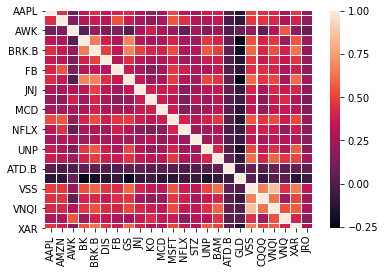

In [57]:
import seaborn as sb
#daily_return.corr()
sb.heatmap(daily_return.corr(),linewidth=0.05)